In [1]:
import sys
sys.path.append('..')

from baselines.cnn.trainer import Trainer

c:\Users\iwama\Desktop\Maciej\Eng\meteoapp-data\venv\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


In [2]:
trainer = Trainer()

Epoch 1/1000:
Train Loss: 0.14656590662182195, Last LR: 0.001
Val Loss: 0.10487393120380296
---------
Epoch 2/1000:
Train Loss: 0.09871385335309865, Last LR: 0.001
Val Loss: 0.09031693097459127
---------
Epoch 3/1000:
Train Loss: 0.09262729459633566, Last LR: 0.001
Val Loss: 0.08846195012535134
---------
Epoch 4/1000:
Train Loss: 0.0906898330233685, Last LR: 0.001
Val Loss: 0.08756537450707122
---------
Epoch 5/1000:
Train Loss: 0.08946518868412057, Last LR: 0.001
Val Loss: 0.08676501577847624
---------
Epoch 6/1000:
Train Loss: 0.08859566684863339, Last LR: 0.001
Val Loss: 0.08623477909458827
---------
Epoch 7/1000:
Train Loss: 0.08792735533150908, Last LR: 0.001
Val Loss: 0.08578179706245252
---------
Epoch 8/1000:
Train Loss: 0.08733023647984413, Last LR: 0.001
Val Loss: 0.08537848881662709
---------
Epoch 9/1000:
Train Loss: 0.08681854482178819, Last LR: 0.001
Val Loss: 0.08500848482937029
---------
Epoch 10/1000:
Train Loss: 0.08637540159772521, Last LR: 0.001
Val Loss: 0.08462531

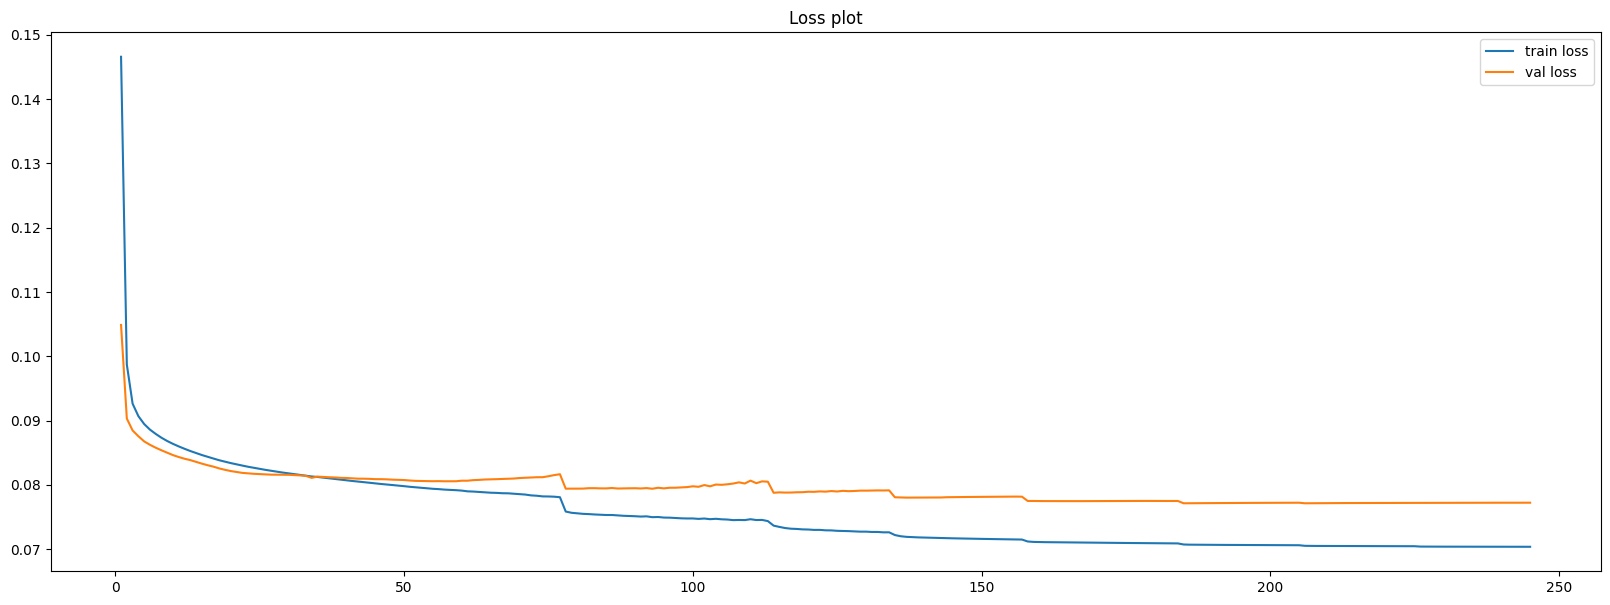

In [3]:
trainer.train(1000)

In [4]:
# trainer.load_model("./model_state2.pt")

RMSE for t2m: 1.2994322776794434; MAE for t2m: 1.0237370729446411;
RMSE for sp: 1.8890571594238281; MAE for sp: 1.4383134841918945;
RMSE for tcc: 0.2401387095451355; MAE for tcc: 0.1792307049036026;
RMSE for u10: 1.2640535831451416; MAE for u10: 0.9758343696594238;
RMSE for v10: 1.3090457916259766; MAE for v10: 1.0064057111740112;
RMSE for tp: 0.00012522954784799367; MAE for tp: 7.468878902727738e-05;


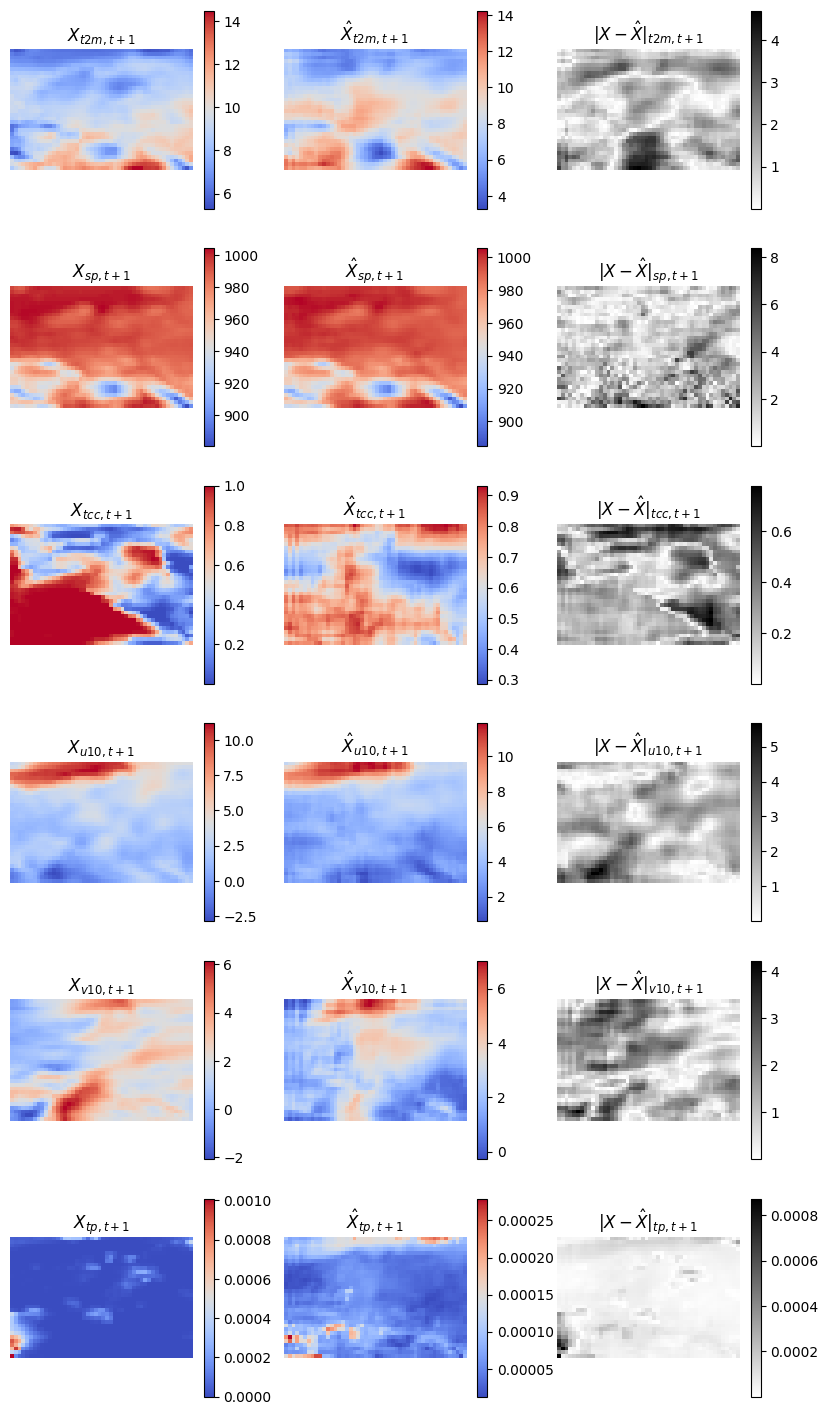

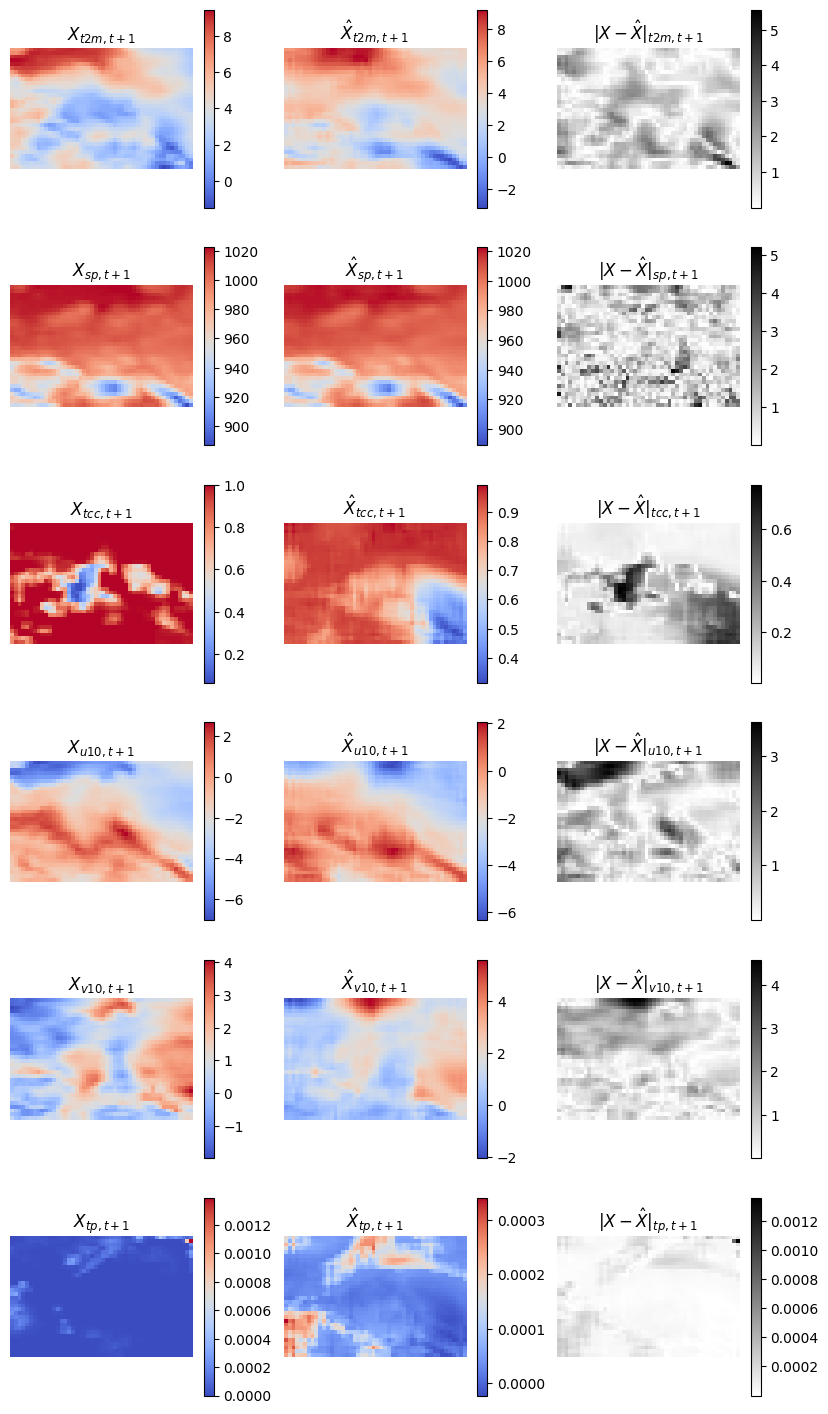

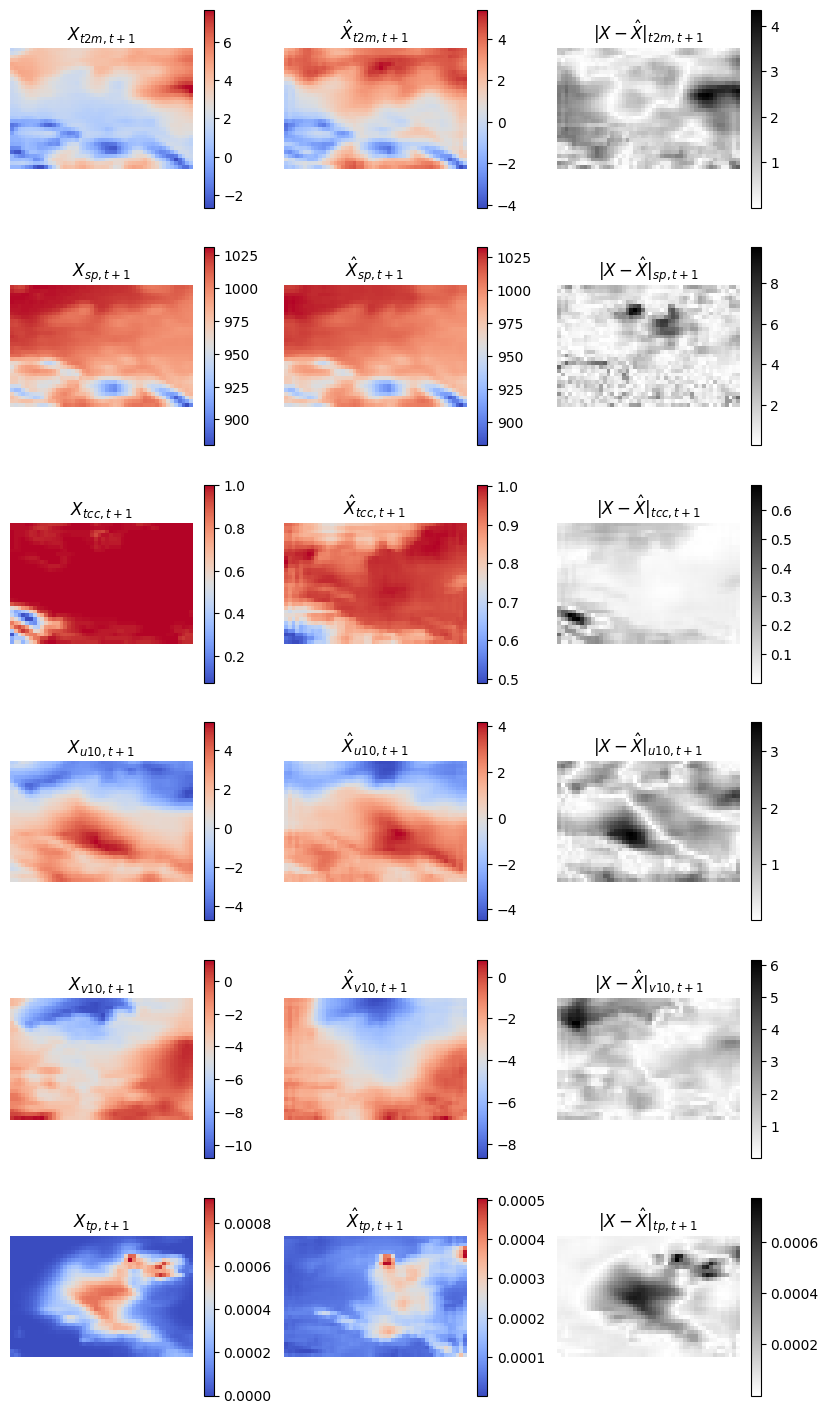

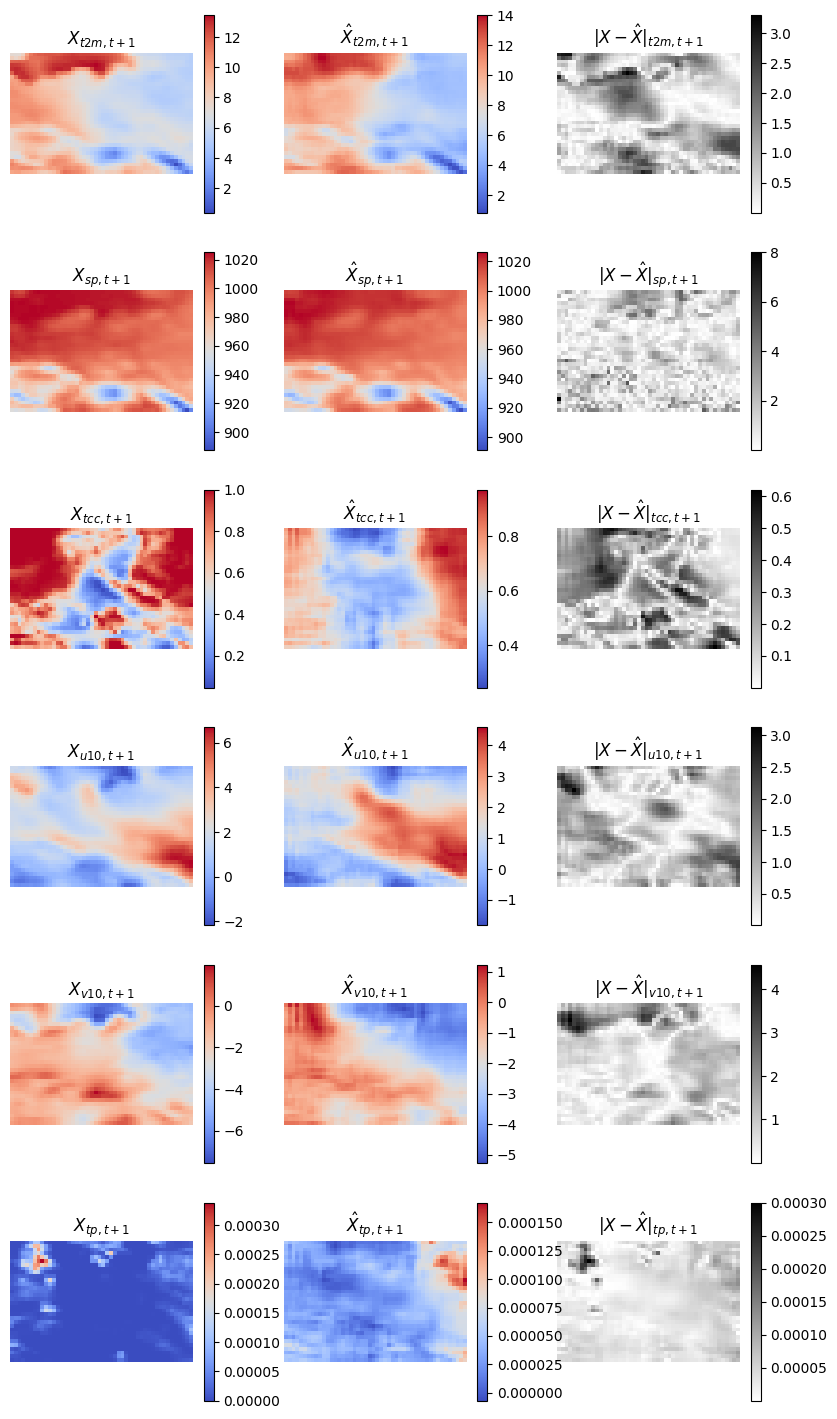

In [5]:
trainer.plot_predictions(data_type='train')

RMSE for t2m: 1.7817821502685547; MAE for t2m: 1.3800411224365234;
RMSE for sp: 1.7555691003799438; MAE for sp: 1.3491601943969727;
RMSE for tcc: 0.2468367964029312; MAE for tcc: 0.1938062459230423;
RMSE for u10: 1.0527689456939697; MAE for u10: 0.8230421543121338;
RMSE for v10: 1.130672574043274; MAE for v10: 0.8798523545265198;
RMSE for tp: 0.00021079076395835727; MAE for tp: 9.78733878582716e-05;


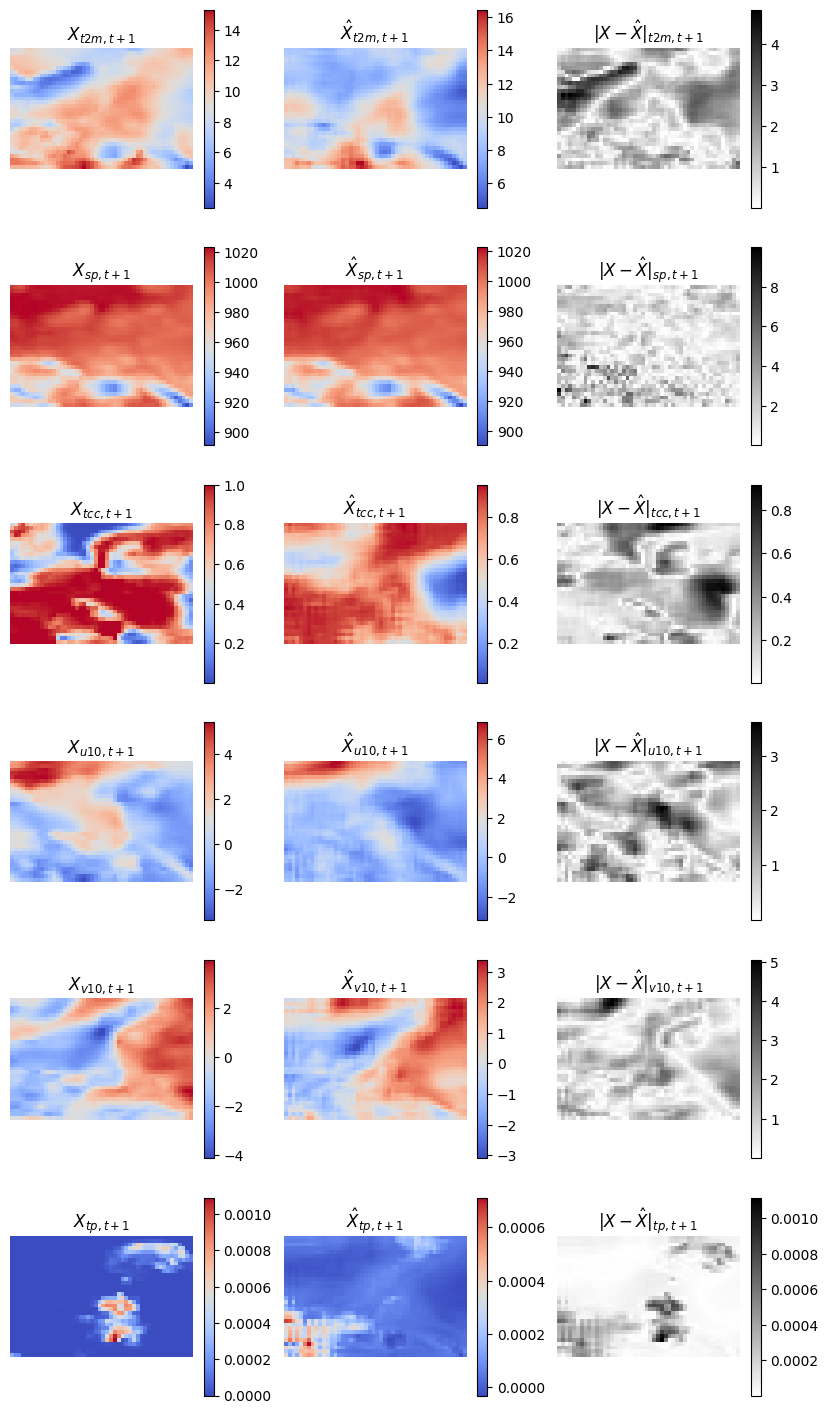

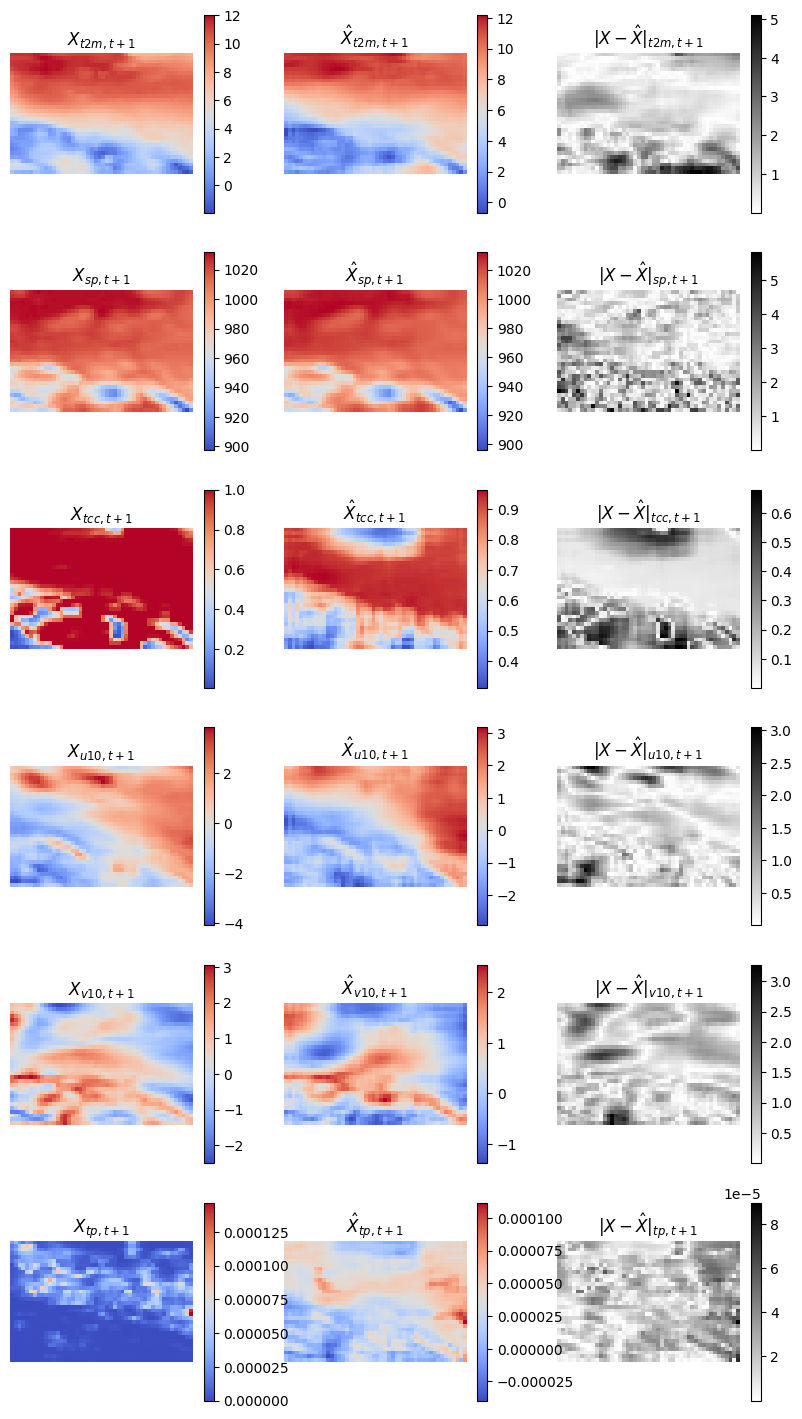

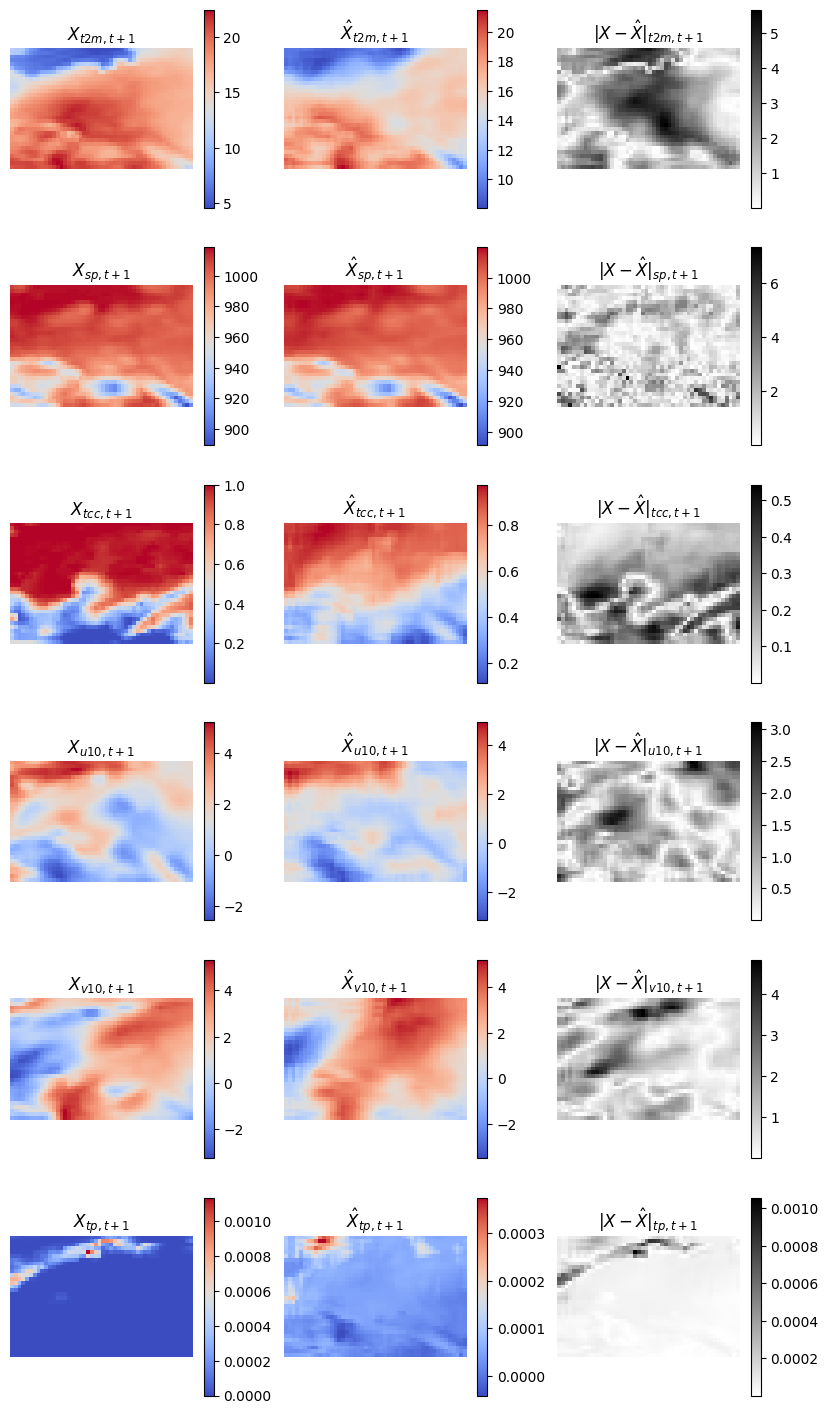

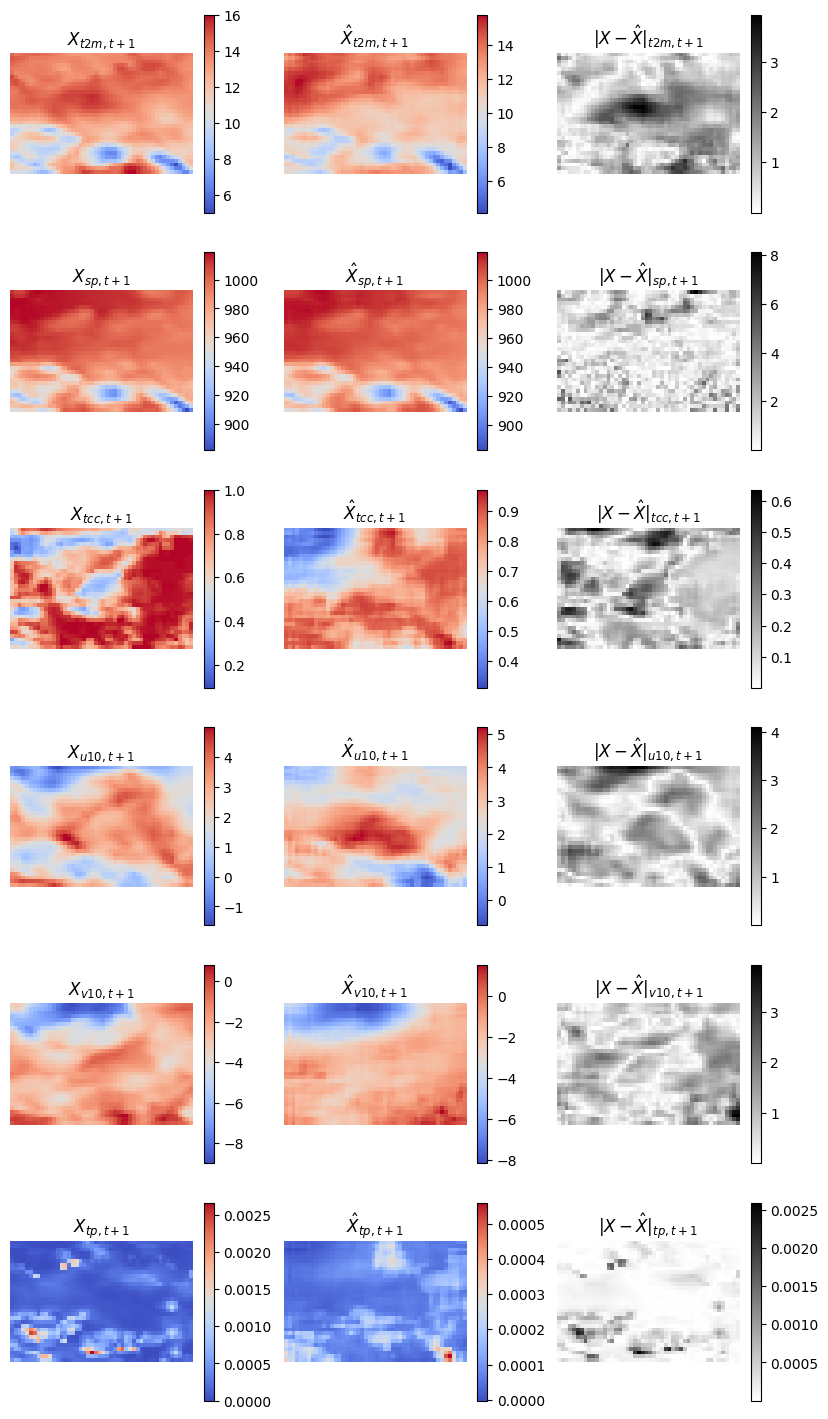

In [6]:
trainer.plot_predictions(data_type='test')